In [1]:
## Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pyOptimalEstimation as pyOE
import os
import sys
import re
import scipy.stats as stats
import seaborn as sns

## append paths
sys.path.append('C:/Users/Ida Olsen/Documents/Speciale_2022/scripts')
parrent_dir = "C:\\Users\\Ida Olsen\\Documents\\Speciale_2022"
sys.path.append(parrent_dir + '\\smrt')
sys.path.append(parrent_dir + '\\Ida_passive_SMRT\\Ida_passive_SMRT\\Code')

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt.interface.iem_fung92_brogioni10 import IEM_Fung92_Briogoni10
from smrt import SMRTError
from IPython.display import clear_output

## self made modules
from Snowpit_class import Snowpit_info
from roughness import roughness
from Make_plots import plot_freq
from forward_functions import forward_mean, forward_OIB
from prepare_inputs_OE import prepare_inputs, prepare_inputs_FYI
import prepare_inputs_OE as piO

In [2]:
def corrMat(self, data):
    ## Make correlation matrix - input covariance matrix
    corrMat = np.zeros(data.shape)
    sigmas = np.diag(data)**(1/2)
    rows = range(data.shape[0])
    cols = range(data.shape[1])
    for row in rows:
        sigma1 = sigmas[row]
        for col in cols:
            sigma2 = sigmas[col]

            corrMat[row][col] = np.array(data)[row][col]/(sigma1*sigma2)

    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(corrMat, cmap="inferno")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(data.keys())), labels=data.keys())
    ax.set_yticks(np.arange(len(data.keys())), labels=data.keys())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    for i in range(len(data.keys())):
        for j in range(len(data.keys())):
            if np.round(corrMat[i, j],2) > 0.5:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                       ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                               ha="center", va="center", color="w")

    ax.set_title(r'Output correlation matrix')
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


    fig.tight_layout()
    plt.show()
    
def covMat(self, data, title):
    for var in self.x_vars:
        data[var][var] = data[var][var]**(1/2)
    ## plot modified covariance matrix
    # print(data['lex']['lex'])
    ## get std
    try:
       data['lex']['lex'] = data['lex']['lex']*1e1
    except:
        pass
    try:
        data['sal']['sal'] = data['sal']['sal']*1e1
    except:
        pass
    try:
        data['Tsur']['Tsur'] = data['Tsur']['Tsur']/1e2
    except:
        pass
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(
        data*1e2,
        annot=True, 
        fmt='.4f', 
        ax=ax, 
        linewidths=.05, 
        cbar_kws={'label':'Modified Covariance [cm,cm,mm,mm,PSU,PSU,cm]'}
    )
    ax.set_title(title)
    plt.show()
def makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB):
    nl_snow = 2
    x_vars = list(x_upperLimit.keys())
    forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow, "n": 0, "nls":1, "avg":True, "sim":True}
    oe = pyOE.optimalEstimation(
    x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
    ,forwardKwArgs=forwardKwArgs
    ,x_lowerLimit=x_lowerLimit
    ,x_upperLimit=x_upperLimit
    )
    return oe

In [3]:
FYI_data = piO.OIB_data('FYI')

FYI_OIB_SIM = np.concatenate([np.mean(FYI_data.TbV_sim, axis=0), np.mean(FYI_data.TbH_sim, axis=0)])
FYI_OIB_AMSR = np.concatenate([np.mean(FYI_data.TbV_AMSR_all, axis=0), np.mean(FYI_data.TbH_AMSR_all, axis=0)])

FYI_OIB_AMSR_std = np.concatenate([np.std(FYI_data.TbV_AMSR_all, axis=0), np.std(FYI_data.TbH_AMSR_all, axis=0)])

## Make simulated data with noise

FYI_OIB_SIM_gaussian = FYI_OIB_SIM

In [4]:
## Define name of y-variables
y_vars = ["6V", "10V", "18V", "23V", "36V", "6H", "10H", "18H", "23H", "36H"] 
# Define values
y_obs  = FYI_OIB_SIM_gaussian

## covariance matrix for TBs - 10X10 matrix
y_cov = np.diag([1.0**2]*10) #  + [1.0]*5)# np.diag(FYI_OIB_AMSR_std)*2

# Define name of x-variables
x_vars = ["SD"]
## prepare first guess, covariance matrix, upper and lower limits
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(x_vars, sim=True, nls=1)
print(x_ap)

{'SD': 0.0}
{'SD': 1.0}
[0.12067324]


['SD']
[0.12067324]


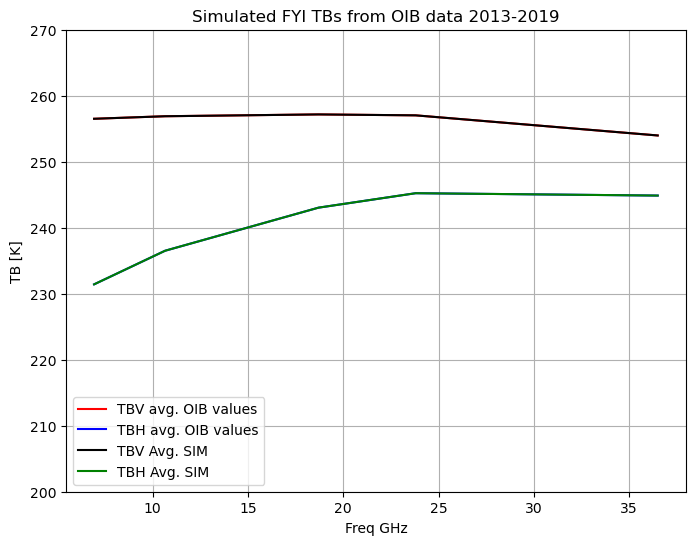

[-1.47048240e-09  3.73228204e-09 -3.08625658e-09 -3.49461970e-09
  2.78177481e-09 -2.45950105e-09  1.16466481e-09 -1.22383881e-10
  5.04655873e-10 -3.72105546e-09]
----------------------------
-------AVG VALUES-----------
[0.12067324 0.03      ]
[0.00021488 0.00025217]
[0.00088802 0.0086732 ]
253.0837746478873
1.4398281690140846
----------------------------
-------X ap-----------
0.12067323943661976


In [5]:
## Plots results
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

nl_snow = 2
x_vars = list(x_upperLimit.keys())
print(x_vars)
print(x_ap)
resStart = forward_OIB(x_ap, x_vars, nl_snow, 0, nls=1, avg=True, sim=True)
# resStart = forward_OIB(x_ap, x_vars, nl_snow, 0,avg=True, sim=True)

y = resStart[:5]
plt.plot(freqs, y, c='r',label = 'TBV avg. OIB values')
y = resStart[5:]
plt.plot(freqs,y, c='b', label = 'TBH avg. OIB values')
y = FYI_OIB_SIM[:5]
plt.plot(freqs, y, c='k', label = 'TBV Avg. SIM')
y = FYI_OIB_SIM[5:]
plt.plot(freqs, y, c='green', label = 'TBH Avg. SIM')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

print(FYI_OIB_SIM-resStart)

print("----------------------------")
print("-------AVG VALUES-----------")
print(np.mean(FYI_data.sd, axis=0))
print(np.mean(FYI_data.sd_lex, axis=0))
print(np.mean(FYI_data.sd_sal, axis=0))
print(np.mean(FYI_data.skt, axis=0))
print(np.mean(FYI_data.sit))

print("----------------------------")
print("-------X ap-----------")
print(x_ap[0])


{'SD': 0.0}
{'SD': 1.0}


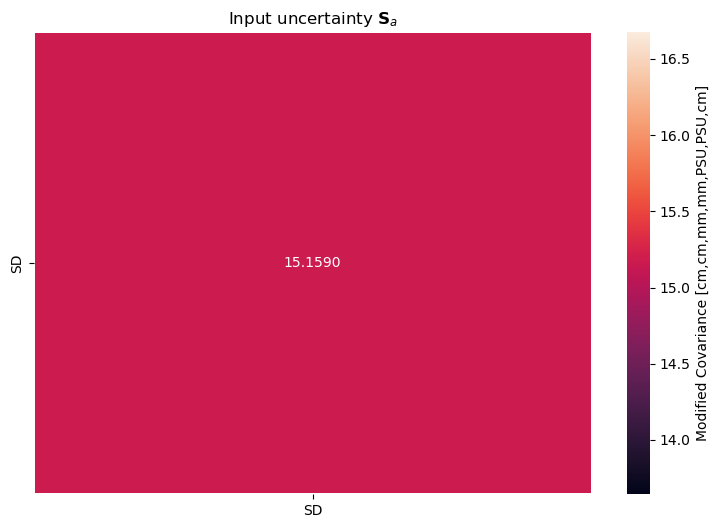

In [6]:
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(x_vars, sim=True, nls=1)
x_cov = np.array([[x_cov]])*10

oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB)
title = r'Input uncertainty $\mathbf{S}_{a}$'
covMat(oe_show, oe_show.S_a, title)

Text(0.5, 1.0, 'Measurement uncertainty $\\mathbf{S}_{y}$')

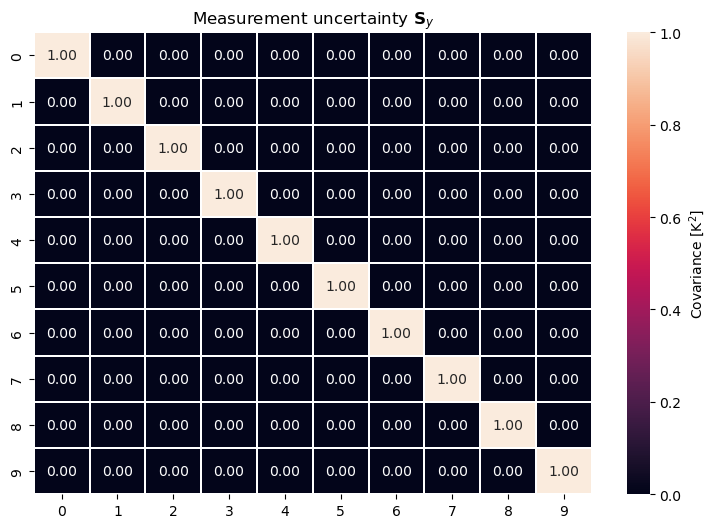

In [7]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    y_cov, 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [K$^2$]'}
)
ax.set_title(r'Measurement uncertainty $\mathbf{S}_{y}$')

In [8]:
## Iterate over different start guesses


nl_snow=2
x_vars = list(x_upperLimit.keys())
forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow, "n": 0, "nls":1, "avg":True, "sim":True}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,convergenceFactor=10
        )
# run the optimization and print outputs
oe.doRetrieval(maxIter=8)
print('Jacobian matrix:\n', oe.getJacobian(oe.x_op, oe.y_op)[0])

0.62 s, iteration 1, degrees of freedom: 1.00 of 1, converged (x-space):  0.000
0.84 s, iteration 2, degrees of freedom: 1.00 of 1, done.  0.000
Jacobian matrix:
      perturbed SD
6V      24.612887
10V     25.158650
18V     23.637319
23V     21.149325
36V     18.324542
6H      41.516915
10H     53.782776
18H     60.674378
23H     56.655553
36H     44.684079


In [9]:
## Iterate over different start guesses
SD_out = []
cc = []
SD0 = np.linspace(0.05, 0.30, 10)
for sd0 in SD0:
    x_ap[0] =sd0 
    ## define extra arguments to forward function
    nl_snow=2
    x_vars = list(x_upperLimit.keys())
    forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow, "n": 0, "nls":1, "avg":True, "sim":True}
    # define the optimal estimation
    oe = pyOE.optimalEstimation(
            x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
            ,forwardKwArgs=forwardKwArgs
            ,x_lowerLimit=x_lowerLimit
            ,x_upperLimit=x_upperLimit
            ,convergenceFactor=10
            )
    # run the optimization and print outputs
    oe.doRetrieval(maxIter=8)
    SD_out.append(oe.x_op['SD'])
    cc.append(oe.S_op)


0.59 s, iteration 1, degrees of freedom: 1.00 of 1, not converged (x-space):  0.987
0.82 s, iteration 2, degrees of freedom: 1.00 of 1, converged (x-space):  0.008
1.60 s, iteration 3, degrees of freedom: 1.00 of 1, done.  0.000
2.23 s, iteration 1, degrees of freedom: 1.00 of 1, converged (x-space):  0.005
3.13 s, iteration 2, degrees of freedom: 1.00 of 1, done.  0.000
2.22 s, iteration 1, degrees of freedom: 1.00 of 1, converged (x-space):  0.016
3.14 s, iteration 2, degrees of freedom: 1.00 of 1, done.  0.000
2.26 s, iteration 1, degrees of freedom: 1.00 of 1, not converged (x-space):  0.155
3.15 s, iteration 2, degrees of freedom: 1.00 of 1, converged (x-space):  0.002
4.00 s, iteration 3, degrees of freedom: 1.00 of 1, done.  0.000
2.15 s, iteration 1, degrees of freedom: 1.00 of 1, not converged (x-space):  2.610
3.03 s, iteration 2, degrees of freedom: 1.00 of 1, converged (x-space):  0.014
3.94 s, iteration 3, degrees of freedom: 1.00 of 1, done.  0.000
2.17 s, iteration 1, de

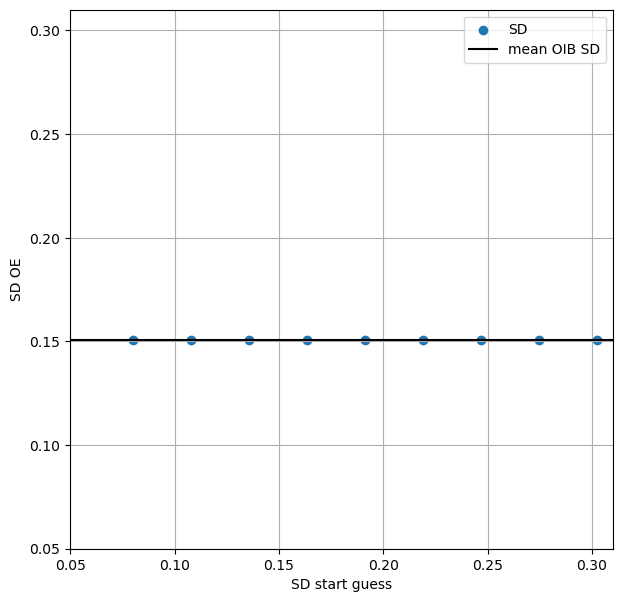

In [10]:

plt.figure(figsize=(7,7))
plt.scatter(np.array(SD0)+0.03, np.array(SD_out)+0.03, label='SD')
plt.xlabel('SD start guess')
plt.ylabel('SD OE')
plt.axhline(np.mean(np.sum(FYI_data.sd, axis=1)), color='k', label='mean OIB SD')
plt.xlim([0.05,0.31])
plt.ylim([0.05,0.31])
plt.legend()
plt.grid()
plt.show()

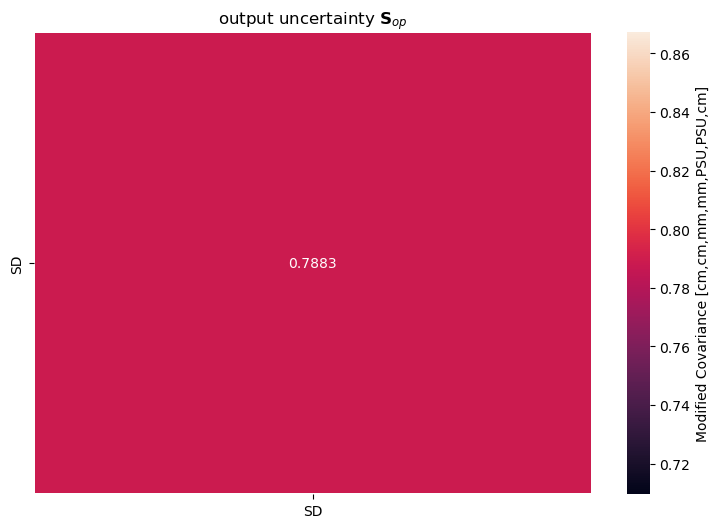

In [12]:
# oe.K
# corrMat(oe.S_op)
title = r'output uncertainty $\mathbf{S}_{op}$'
covMat(oe,oe.S_op, title)

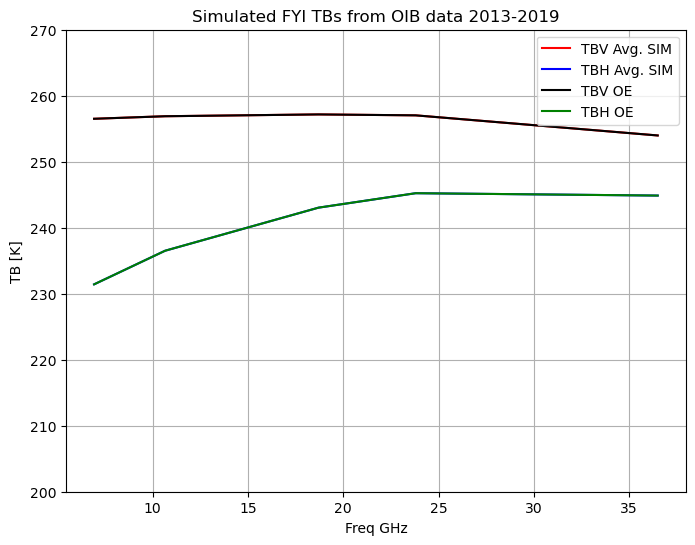

In [13]:
## Plots results
res = oe.y_op
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

y = FYI_OIB_SIM[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. SIM')
y = FYI_OIB_SIM[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. SIM')
y = res[:5]
plt.plot(freqs, y, c='k', label = 'TBV OE')
y = res[5:]
plt.plot(freqs,y, c='green', label = 'TBH OE')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

In [14]:
chiSquareTest = oe.chiSquareTest(significance=0.05)
print('\nTests passed:\n' ,chiSquareTest[0])

Warning. Singular Matrix with rank 1 instead of 10. (This is typically save to ignore)       

Tests passed:
 chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


In [15]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

SD   NaN
dtype: float64


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Define name of x-variables
x_vars = ["SD"]
## prepare first guess, covariance matrix, upper and lower limits
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] =  prepare_inputs_FYI(x_vars, sim=True, nls=1)
x_cov = np.array([[x_cov]])*10

nl_snow = 2
x_vars = list(x_upperLimit.keys())

results = []
x_optimals = []
ns = 100
nn = [i for i in range(ns)]
no = []
SD_not_converged = []

for TbV, TbH, n in zip(FYI_data.TbV_sim[:ns], FYI_data.TbH_sim[:ns], range(len(FYI_data.skt[:ns]))):
    forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow, "n":n, "nls":1, "avg":False, "sim":True}
    y_obs = np.concatenate((TbV, TbH))
    oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        )
    
    oe.doRetrieval(maxIter=10)
    try:
        oe.y_op[0]
        x_optimals.append(oe.x_op)
        results.append(np.array(oe.y_op))
    except:
        pass

In [ ]:
nnn = np.array(nn, dtype=int)
fig, ax = plt.subplots(5, figsize=(8,8), sharex=True)
freqs=[6.9,10.7,18.7,23.8,36.5];
for i in range(5):
    bins = np.linspace(220, 270, 100)
    ax[i].hist([res[i] for res in results], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].hist([TbV[i] for TbV in FYI_data.TbV_sim[:ns]], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].hist([res[i+5] for res in results], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].hist([TbH[i] for TbH in FYI_data.TbH_sim[:ns]], bins=bins, rwidth=0.85, alpha=0.7)
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(freqs[i]) + ' GHz')
plt.xlabel('TB [K]')
plt.legend(['TBV OE', 'TBV sim', 'TBH OE', 'TBH sim'], bbox_to_anchor=(1.35, 3.5))
# plt.legend(['TBV OE', 'TBV generated', 'TBH OE', 'TBH generated'], bbox_to_anchor=(1.35, 3.5))
# plt.title('Simulated and Generated TBs')

In [ ]:
# print([x_optim for x_optim in x_optimals])
SD_OE = []
SD_OIB = []
for x_optim,n in zip(x_optimals, FYI_data.sd[nnn]):
    try:
        SD_OE.append([x_optim['SD']])
        SD_OIB.append(np.sum(n))
        
    except:
        print('convergence was not reached at: ', x_optim)
                      
diag = np.linspace(0,400,400)

plt.figure(figsize=(6,6))
plt.scatter(SD_OIB, SD_OE)
plt.plot(diag, diag, 'k')
plt.grid()
plt.title('SD comp OE/OIB')
plt.xlabel('SD OIB')
plt.ylabel('SD OE')
plt.xlim([0.03, 0.3])
plt.ylim([0.03, 0.3])